In [1]:
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from easydict import EasyDict as edict
from imutils.paths import list_images
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from monai.data import DataLoader
from monai.networks import nets
from monai import transforms
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn as nn
import seaborn as sns 
import numpy as np
import torch
import cv2

from utils.dataset_util import *

/opt/conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/brain_tumor'

args               = {}
args['lr']         = 3e-4
args['epochs']     = 25
args['device']     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['batch_size'] = 32
args               = edict(args)

In [3]:
get_labels = lambda image_paths: [image_path.split(SEP)[-2] for image_path in image_paths]

train_paths  = sorted(list_images(f'{DATA_PATH}/Training'))
test_paths   = sorted(list_images(f'{DATA_PATH}/Testing'))

train_labels = get_labels(train_paths)
test_labels  = get_labels(test_paths)

lb2idx       = {lb  : idx for idx,  lb in enumerate(set(train_labels))}
idx2lb       = {idx :  lb for lb , idx in lb2idx.items()}

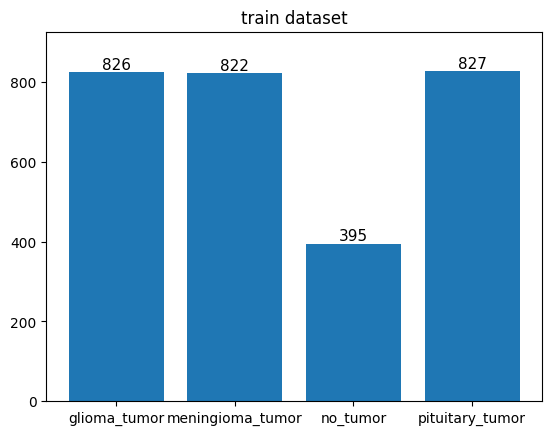

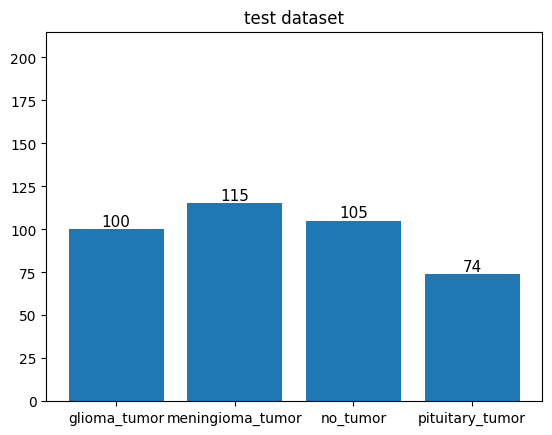

In [4]:
display_distribution(train_labels)
display_distribution(test_labels, dtype = 'test')

train_labels = [lb2idx[lb] for lb in train_labels]
test_labels  = [lb2idx[lb] for lb in  test_labels]

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(train_paths, train_labels, stratify = train_labels,
                                                      test_size = 0.2, shuffle = True)

In [6]:
class TumorDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transform = {}
        self.transform['train'] = transforms.Compose([
                                    transforms.Resize(spatial_size = (299, 299)),
                                    transforms.RandRotate(range_x = np.pi / 12, prob = 0.5, keep_size = True), 
                                    transforms.RandFlip(spatial_axis = 0, prob = 0.5)
                                ])
        
        self.transform['valid'] = transforms.Compose([
                                    transforms.Resize(spatial_size = (299, 299)),
                                ])
        
    def __len__(self):
        
        return len(self.images)
    
    
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis = 0)
        image = self.transform[self.dtype](image)
    
        return image, self.labels[idx]

In [7]:
train_dataset = TumorDataset(train_x   , train_y)
valid_dataset = TumorDataset(valid_x   , valid_y    , dtype = 'valid')
test_dataset  = TumorDataset(test_paths, test_labels, dtype = 'valid')

train_loader  = DataLoader(train_dataset, batch_size = args.batch_size, shuffle =  True)
valid_loader  = DataLoader(valid_dataset, batch_size = args.batch_size, shuffle = False)
test_loader   = DataLoader(test_dataset , batch_size =               1, shuffle = False)

train_sample  = next(iter(train_loader))
image, label  = train_sample
image.shape, len(label)

(torch.Size([32, 1, 299, 299]), 32)

In [8]:
model = nets.EfficientNetBN('efficientnet-b3', spatial_dims = 2, 
                           in_channels = 1, num_classes = len(set(train_labels)))
model = model.to(args.device)

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), args.lr)

In [10]:
def train(model, loader, optimizer):
    model.train()
    train_loss, correct = 0, 0
    
    for image, lb in (tbar := tqdm(loader)):
        tbar.set_description('[train]     ')
        
        image, lb = image.to(args.device), lb.to(args.device)
        optimizer.zero_grad()
        
        output    = model(image)
        loss      = loss_function(output, lb)
        
        loss.backward()
        optimizer.step()
        
        pred        = output.max(1, keepdim = True)[1]
        correct    += pred.eq(lb.view_as(pred)).sum().item()
        train_loss += loss.item()
        
    train_loss /= len(loader.dataset)
    train_acc   = 100 * correct / len(loader.dataset)
    
    return train_loss, train_acc


def validation(model, loader):
    
    model.eval()
    valid_loss, correct = 0, 0
    
    with torch.no_grad():
        for image, lb in (vbar := tqdm(loader)):
            vbar.set_description('[validation]')
            
            image, lb   = image.to(args.device), lb.to(args.device)
            output      = model(image)
            loss        = loss_function(output, lb)
            pred        = output.max(1, keepdim = True)[1]
            
            correct    += pred.eq(lb.view_as(pred)).sum().item()
            valid_loss += loss.item()
    
    valid_loss /= len(loader.dataset)
    valid_acc   = 100 * correct / len(loader.dataset)
    
    return valid_loss, valid_acc


def evaluation(model, loader):
  model.eval()
  corrects = 0
  preds, gt = [], []

  for images, labels in (ebar := tqdm(loader)):
    ebar.set_description('[evaluation]')
    images, labels = images.to(args.device), labels.to(args.device)

    outputs = model(images)

    _, pred = torch.max(outputs, 1)
    corrects += torch.sum(pred == labels.data)

    preds.append(pred.item())
    gt.append(labels.data.item())

  acc = corrects / len(test_loader)
  print(f'Test Accuracy : {acc:.3f}\n')

  return classification_report(gt, preds, target_names = lb2idx.keys())

In [11]:
history = {
                'train_loss' : [],
                'train_acc'  : [],
                'valid_loss' : [],
                'valid_acc'  : []
            }
best_loss, best_epoch = 10000, 0
best_model            = None

## 학습을 돌려보자
for epoch in range(1, args.epochs + 1):
    print(f'[{epoch} / {args.epochs}]')
    train_loss, train_acc = train(model, train_loader, optimizer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    valid_loss, valid_acc = validation(model, valid_loader)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    print(f'Train Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \
    Valid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc:.3f} \n')

    if valid_loss < best_loss:
        
        best_loss  = valid_loss
        best_epoch = epoch
        best_model = model
        
        print(f'saved new best model at {best_epoch} with valid loss : {valid_loss:.3f}')

[1 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]


Train Loss : 0.035 | Train Acc : 72.953     Valid Loss : 0.079 | Valid Acc : 48.084 

saved new best model at 1 with valid loss : 0.079
[2 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  7.31it/s]


Train Loss : 0.011 | Train Acc : 89.721     Valid Loss : 0.016 | Valid Acc : 88.328 

saved new best model at 2 with valid loss : 0.016
[3 / 25]


[validation]: 100%|██████████| 18/18 [00:03<00:00,  5.98it/s]


Train Loss : 0.007 | Train Acc : 93.423     Valid Loss : 0.012 | Valid Acc : 90.767 

saved new best model at 3 with valid loss : 0.012
[4 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.07it/s]


Train Loss : 0.007 | Train Acc : 93.728     Valid Loss : 0.006 | Valid Acc : 93.902 

saved new best model at 4 with valid loss : 0.006
[5 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.15it/s]


Train Loss : 0.004 | Train Acc : 95.732     Valid Loss : 0.006 | Valid Acc : 94.251 

[6 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s]


Train Loss : 0.003 | Train Acc : 97.038     Valid Loss : 0.008 | Valid Acc : 92.683 

[7 / 25]


[validation]: 100%|██████████| 18/18 [00:03<00:00,  5.99it/s]


Train Loss : 0.003 | Train Acc : 96.821     Valid Loss : 0.018 | Valid Acc : 89.373 

[8 / 25]


[validation]: 100%|██████████| 18/18 [00:03<00:00,  5.97it/s]


Train Loss : 0.003 | Train Acc : 97.605     Valid Loss : 0.004 | Valid Acc : 95.645 

saved new best model at 8 with valid loss : 0.004
[9 / 25]


[validation]: 100%|██████████| 18/18 [00:03<00:00,  5.89it/s]


Train Loss : 0.002 | Train Acc : 97.735     Valid Loss : 0.005 | Valid Acc : 95.645 

[10 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.10it/s]


Train Loss : 0.002 | Train Acc : 97.779     Valid Loss : 0.007 | Valid Acc : 93.902 

[11 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.28it/s]


Train Loss : 0.002 | Train Acc : 98.519     Valid Loss : 0.005 | Valid Acc : 96.167 

[12 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.19it/s]


Train Loss : 0.002 | Train Acc : 97.953     Valid Loss : 0.009 | Valid Acc : 94.425 

[13 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]


Train Loss : 0.003 | Train Acc : 97.692     Valid Loss : 0.005 | Valid Acc : 95.993 

[14 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.31it/s]


Train Loss : 0.003 | Train Acc : 97.343     Valid Loss : 0.007 | Valid Acc : 95.993 

[15 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]


Train Loss : 0.001 | Train Acc : 98.606     Valid Loss : 0.007 | Valid Acc : 96.516 

[16 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.09it/s]


Train Loss : 0.001 | Train Acc : 99.129     Valid Loss : 0.006 | Valid Acc : 95.819 

[17 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]


Train Loss : 0.001 | Train Acc : 99.085     Valid Loss : 0.003 | Valid Acc : 97.561 

saved new best model at 17 with valid loss : 0.003
[18 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]


Train Loss : 0.001 | Train Acc : 98.824     Valid Loss : 0.004 | Valid Acc : 97.038 

[19 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.24it/s]


Train Loss : 0.001 | Train Acc : 99.347     Valid Loss : 0.007 | Valid Acc : 95.993 

[20 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


Train Loss : 0.001 | Train Acc : 99.085     Valid Loss : 0.013 | Valid Acc : 91.986 

[21 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]


Train Loss : 0.001 | Train Acc : 98.563     Valid Loss : 0.006 | Valid Acc : 95.819 

[22 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.02it/s]


Train Loss : 0.001 | Train Acc : 98.868     Valid Loss : 0.004 | Valid Acc : 96.516 

[23 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.70it/s]


Train Loss : 0.002 | Train Acc : 98.301     Valid Loss : 0.012 | Valid Acc : 93.728 

[24 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  6.51it/s]


Train Loss : 0.001 | Train Acc : 98.998     Valid Loss : 0.006 | Valid Acc : 96.167 

[25 / 25]


[validation]: 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

Train Loss : 0.001 | Train Acc : 99.085     Valid Loss : 0.004 | Valid Acc : 97.213 



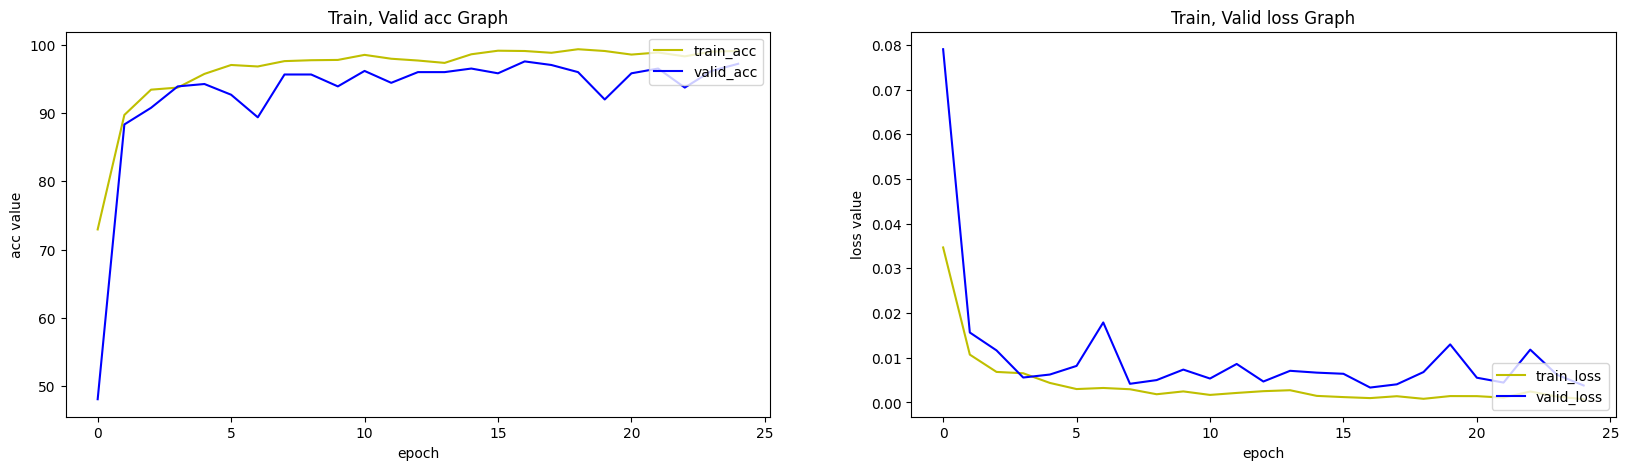

In [12]:
display_history(history, args.epochs)

In [13]:
print(evaluation(best_model, test_loader))

[evaluation]: 100%|██████████| 394/394 [00:15<00:00, 25.03it/s]

Test Accuracy : 0.774

                  precision    recall  f1-score   support

meningioma_tumor       0.67      0.97      0.79       115
 pituitary_tumor       0.96      0.86      0.91        74
        no_tumor       0.78      1.00      0.88       105
    glioma_tumor       1.00      0.24      0.39       100

        accuracy                           0.77       394
       macro avg       0.85      0.77      0.74       394
    weighted avg       0.84      0.77      0.73       394

